In [1]:
# ---------- 1) Load & clean ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

def load_and_clean(path="cars.csv"):
    df = pd.read_csv(path, na_values=["?", "NA", "NaN", ""])
    df.columns = df.columns.str.strip().str.lower()
    df = df.rename(columns={"weigth": "weight"})  # fix typo if present

    # Coerce numeric
    for col in ["mpg", "cylinders", "horsepower", "weight", "year"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Origin as string labels (some files use 1/2/3)
    if "origin" in df.columns:
        if pd.api.types.is_numeric_dtype(df["origin"].dropna()):
            df["origin"] = df["origin"].map({1: "US", 2: "Europe", 3: "Japan"})
        df["origin"] = (
            df["origin"].astype(str).str.strip().str.title()
            .replace({"Us": "US", "U.S.": "US"})
        )

    # Expand two-digit years to 1970–1982
    if "year" in df.columns:
        df["year"] = df["year"].apply(
            lambda v: np.nan if pd.isna(v) else (v if v >= 1900 else 1900 + int(v))
        )

    # Impute horsepower for sizing so we don't drop rows
    if "horsepower" in df.columns:
        hp_imp = df["horsepower"].copy()
        if {"cylinders", "year"}.issubset(df.columns):
            hp_imp = hp_imp.fillna(df.groupby(["cylinders", "year"])["horsepower"].transform("median"))
        if "cylinders" in df.columns:
            hp_imp = hp_imp.fillna(df.groupby("cylinders")["horsepower"].transform("median"))
        hp_imp = hp_imp.fillna(df["horsepower"].median())
        df["hp_size"] = hp_imp

    return df

df = load_and_clean("cars.csv")
print("Shape after cleaning:", df.shape)
print("Columns:", list(df.columns))


Shape after cleaning: (392, 8)
Columns: ['model', 'mpg', 'cylinders', 'horsepower', 'weight', 'year', 'origin', 'hp_size']


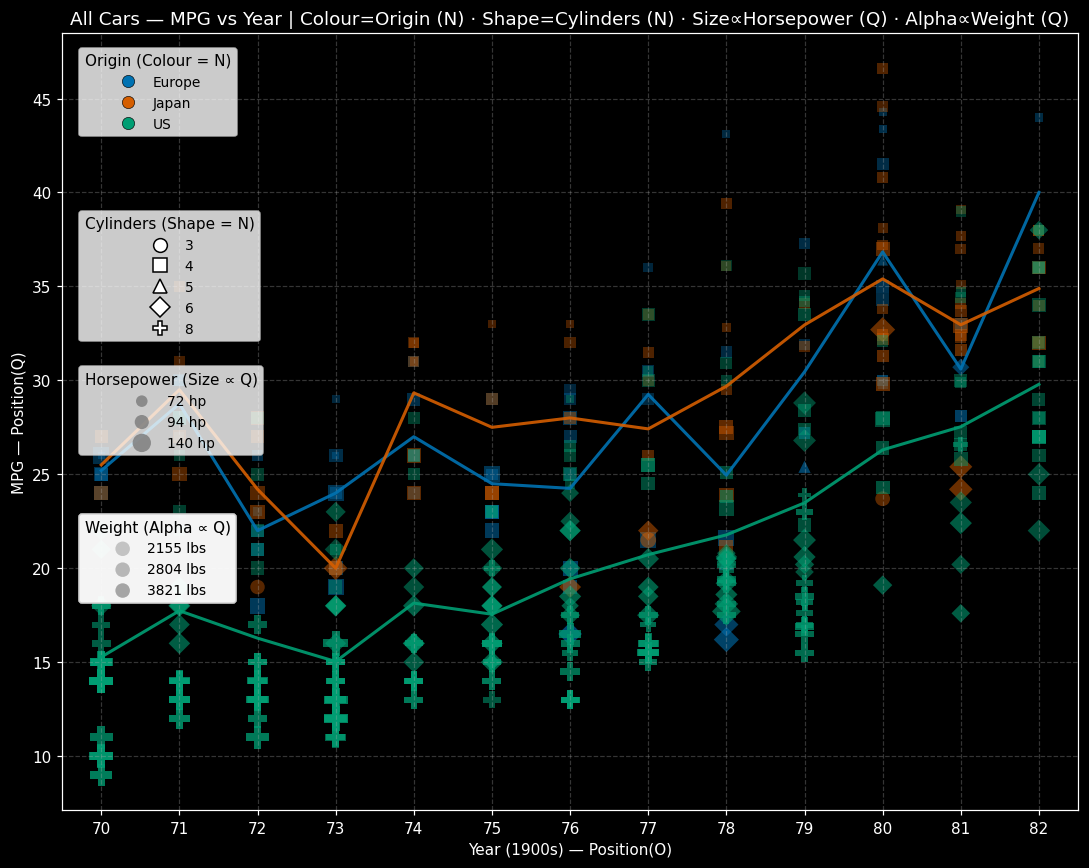

In [2]:
# --- Use the cleaned df from before ---
plot = df.dropna(subset=["mpg", "weight", "cylinders", "origin", "year"]).copy()

# If hp_size not present (from earlier cleaning), fall back to horsepower with median fill
if "hp_size" not in plot.columns:
    hp_tmp = pd.to_numeric(plot.get("horsepower"), errors="coerce")
    plot["hp_size"] = hp_tmp.fillna(hp_tmp.median())

# ----- Size mapping: horsepower (continuous, no discrete legend) -----
hp = plot["hp_size"].astype(float).to_numpy()
hp_min, hp_max = float(np.nanmin(hp)), float(np.nanmax(hp))
def scale_hp(v, smin=24, smax=260):
    if np.isnan(v) or hp_max == hp_min:
        return (smin + smax) / 2
    return smin + (v - hp_min) / (hp_max - hp_min) * (smax - smin)

# ----- Colour: Origin (nominal) — Okabe–Ito palette -----
palette = {"US": "#009E73", "Europe": "#0072B2", "Japan": "#D55E00"}
for o in plot["origin"].unique():
    palette.setdefault(o, "#000000")

# ----- Shape: Cylinders (nominal) -----
unique_cyl = sorted(plot["cylinders"].astype(int).unique())
marker_cycle = ["o", "s", "^", "D", "P", "v", "X", "<", ">"]
marker_map = {c: marker_cycle[i % len(marker_cycle)] for i, c in enumerate(unique_cyl)}

# ----- Alpha (transparency): Weight (quantitative) -----
w = plot["weight"].astype(float).to_numpy()
w_min, w_max = float(np.nanmin(w)), float(np.nanmax(w))
ALPHA_MIN, ALPHA_MAX = 0.30, 0.85  # keep faint points visible
def alpha_from_weight(val):
    if np.isnan(val) or w_max == w_min:
        return (ALPHA_MIN + ALPHA_MAX) / 2
    return ALPHA_MIN + (val - w_min) / (w_max - w_min) * (ALPHA_MAX - ALPHA_MIN)

# ----- X as discrete Year (ordered/interval) -----
plot["year"] = plot["year"].astype(int)

fig, ax = plt.subplots(figsize=(10, 8), dpi=110)

# --- REVERSE BACKGROUND AND GRID COLOURS ---
fig.patch.set_facecolor("black")
ax.set_facecolor("black")
ax.tick_params(colors="white", which="both")
for spine in ax.spines.values():
    spine.set_color("white")
ax.xaxis.label.set_color("white")
ax.yaxis.label.set_color("white")
ax.title.set_color("white")

# Draw per Origin × Cylinders group (so colour+shape are correct)
for o in sorted(plot["origin"].unique()):
    sub_o = plot[plot["origin"] == o]
    base_rgb = mcolors.to_rgb(palette[o])
    for c in unique_cyl:
        sub = sub_o[sub_o["cylinders"] == c]
        if sub.empty:
            continue

        # Per-point alpha based on weight -> build RGBA colors
        alphas = sub["weight"].apply(alpha_from_weight).to_numpy()
        rgba = np.column_stack([
            np.full(len(sub), base_rgb[0]),
            np.full(len(sub), base_rgb[1]),
            np.full(len(sub), base_rgb[2]),
            alphas
        ])

        ax.scatter(
            sub["year"], sub["mpg"],
            s=sub["hp_size"].apply(scale_hp).to_numpy(),
            c=rgba, marker=marker_map[c],
            edgecolors='none'
        )

# ---------- mean trend per origin (yearly mean MPG) ----------
gb = plot.groupby(["origin", "year"], as_index=False)["mpg"].mean()
for o in sorted(plot["origin"].unique()):
    sub = gb[gb["origin"] == o].sort_values("year")
    if not sub.empty:
        ax.plot(sub["year"], sub["mpg"], color=palette[o], linewidth=2.0, alpha=0.9, label=f"{o} mean")

# ---------- SEPARATE LEGENDS (top-left, smaller) ----------
# 1) Origin (colour)
color_handles = [
    Line2D([0], [0], marker="o", linestyle="", markerfacecolor=palette[o],
           markeredgecolor="black", markeredgewidth=0.4, markersize=8, label=o)
    for o in sorted(plot["origin"].unique())
]
leg_origin = ax.legend(
    handles=color_handles, title="Origin (Colour = N)",
    loc="upper left", bbox_to_anchor=(0.01, 0.99),
    frameon=True, prop={"size": 9}, title_fontsize=10
)
ax.add_artist(leg_origin)

# 2) Cylinders (shape)
shape_handles = [
    Line2D([0], [0], marker=marker_map[c], linestyle="",
           markerfacecolor="white", markeredgecolor="black",
           markersize=9, label=str(int(c)))
    for c in unique_cyl
]
leg_cyl = ax.legend(
    handles=shape_handles, title="Cylinders (Shape = N)",
    loc="upper left", bbox_to_anchor=(0.01, 0.78),
    frameon=True, prop={"size": 9}, title_fontsize=10
)
ax.add_artist(leg_cyl)

# 3) Horsepower (size) — use 3 breaks (like ggplot scale_size with set breaks/labels)
hp_vals = hp[~np.isnan(hp)]
hp_breaks = np.round(np.quantile(hp_vals, [0.2, 0.5, 0.8])).astype(int)  # three representative values
size_handles = [
    plt.scatter([], [], s=scale_hp(v), c="#7F7F7F", alpha=0.85, edgecolors="none", label=f"{v} hp")
    for v in hp_breaks
]
leg_size = ax.legend(
    handles=size_handles, title="Horsepower (Size ∝ Q)",
    loc="upper left", bbox_to_anchor=(0.01, 0.58),
    frameon=True, scatterpoints=1, prop={"size": 9}, title_fontsize=10
)
ax.add_artist(leg_size)

# 4) Weight (transparency) — 3 breaks with original-unit labels
w_vals = w[~np.isnan(w)]
w_breaks = np.round(np.quantile(w_vals, [0.2, 0.5, 0.8])).astype(int)
alpha_handles = [
    plt.scatter([], [], s=90, c="#7F7F7F", alpha=alpha_from_weight(v), edgecolors="none", label=f"{v} lbs")
    for v in w_breaks
]
leg_alpha = ax.legend(
    handles=alpha_handles, title="Weight (Alpha ∝ Q)",
    loc="upper left", bbox_to_anchor=(0.01, 0.39),
    frameon=True, scatterpoints=1, prop={"size": 9}, title_fontsize=10
)
ax.add_artist(leg_alpha)

# ---------- axes/ticks (unchanged) ----------
years = sorted(plot["year"].unique())
ax.set_xticks(years)
ax.set_xticklabels([f"{y % 100:02d}" for y in years])
ax.set_xlim(min(years) - 0.5, max(years) + 0.5)

ax.set_xlabel("Year (1900s) — Position(O)")
ax.set_ylabel("MPG — Position(Q)")
ax.set_title("All Cars — MPG vs Year | Colour=Origin (N) · Shape=Cylinders (N) · Size∝Horsepower (Q) · Alpha∝Weight (Q)")
ax.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

